# Perceptual Path Length (PPL)

*Please note that this is an optional notebook, meant to introduce more advanced concepts if you're up for a challenge, so don't worry if you don't completely follow!*

Perceptual path length (PPL) was a metric that was introduced as part of [StyleGAN](https://arxiv.org/abs/1812.04948) to evaluate how well a generator manages to smoothly interpolate between points in its latent space. In essence, if you travel between two points images produced by a generator on a straight line in the latent space, it measures the total "jarringness" of the interpolation when you add together the jarringness of each step. In this notebook, you'll walk through the motivation and mechanism behind PPL.

The [StyleGAN2](https://arxiv.org/abs/1912.04958) paper noted that metric also "correlates with consistency and stability of shapes," which led to one of the major changes between the two papers.

And don't worry, we don't expect you to be familiar with StyleGAN yet - you'll learn more about it later in this course! 

## Perceptual Similarity

Like FID, which you learned about this week, PPL uses the feature embeddings of deep convolutional neural network. Specifically, the distance between two image embeddings as proposed in [The Unreasonable Effectiveness of Deep Features as a Perceptual Metric
](https://arxiv.org/abs/1801.03924) by Zhang et al (CVPR 2018). In this approach, unlike in FID, a VGG16 network is used instead of an InceptionNet. 

Perceptual similarity is closely similar to the distance between two feature vectors, with one key difference: the features are passed through a learned transformation, which is trained to match human intuition on image similarity. Specifically, when shown two images with various transformations from a base image, the LPIPS ("Learned Perceptual Image Patch Similarity") metric is meant to have a lower distance for the image that people think is closer. 

![figure from perceptual similarity paper](https://drive.google.com/uc?id=1JI_4X65Dk-NX0ID4lFiP07rS0LFWq1LZ)
*Figure from [The Unreasonable Effectiveness of Deep Features as a Perceptual Metric
](https://arxiv.org/abs/1801.03924), showing a source image in the center and two transformations of it. Humans generally found the right-side image more similar to the center image than the left-side image, and the LPIPS metric matches this.*


For our implementation, we can use the `lpips` [library](https://github.com/richzhang/PerceptualSimilarity), implemented by the authors of the perceptual similarity paper.


In [1]:
import lpips
# Outside of coursera, you don't need the following five lines:
from shutil import copyfile
import os
cache_path = '/home/jovyan/.cache/torch/hub/checkpoints/'
vgg_file = 'vgg16-397923af.pth'
if not os.path.exists(f"{cache_path}{vgg_file}"):
    print("Moving file to cache")
    os.makedirs(cache_path, exist_ok=True)
    copyfile(vgg_file, f"{cache_path}{vgg_file}")
loss_fn_vgg = lpips.LPIPS(net='vgg')

Moving file to cache
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


You'll define your generator and a function to visualize the images.

In [2]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()



You'll also load a generator, pre-trained on CelebA, like in the main assignment for this week.

In [3]:
z_dim = 64
gen = Generator(z_dim)
gen.load_state_dict(torch.load(f"pretrained_celeba.pth", map_location='cpu')["gen"])
gen = gen.eval()

## From LPIPS to PPL
Note that perceptual path length builds directly on the LPIPS metric.

As you'll learn, StyleGAN does not operate directly on the randomly sampled latent vector. Instead, it learns a mapping $f$ from $z$ to $w$ -- that is, $f(z) = w$. You'll learn more about this later, but for now, all you need to know is that there are two spaces over which you can calculate PPL. 

### Linear Interpolation ($w$-space)

For the $w$ space, PPL is defined as follows using linear interpolation:

First, you sample two points in $w$-space, $w_1 = f(z_1)$ and $w_2 = f(z_2)$, from two randomly sampled points in $z$-space. For simplicity, we'll let $f$ be the identity function here.

In [4]:
map_fn = nn.Identity()
w_1, w_2 = map_fn(torch.randn(1, z_dim)), map_fn(torch.randn(1, z_dim))

You will use your generator to produce two images interpolating between $w_1$ and $w_2$, where the amount of $w_1$ is $t$, one where the amount of $w_1$ is $t+\epsilon$. You can think of $t$ as sampling a random point along the path interpolating between $w_1$ and $w_2$.

You can use the `torch.lerp` function for linear interpolation, and sample a random $t$ uniformly from 0 to 1 using `torch.rand`. Also, here we can set $\epsilon = 2 \cdot 10^{-1}$ for visualization, even though in the StyleGAN paper $\epsilon = 10^{-4}$.


In [24]:
eps = 2e-1
t = torch.rand(1)
interpolated_1 = torch.lerp(w_1, w_2, t)
interpolated_2 = torch.lerp(w_1, w_2, t + eps)
y_1, y_2 = gen(interpolated_1), gen(interpolated_2)

Now you can visualize these images and evaluate their LPIPS:

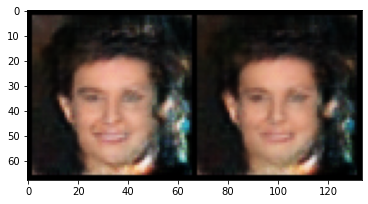

Image LPIPS is 0.07003598660230637


In [25]:
show_tensor_images(torch.cat([y_1, y_2]))
cur_lpips = loss_fn_vgg(y_1, y_2).item()
print(f"Image LPIPS is {cur_lpips}")

Finally, you need to account for the impact of different values of $\epsilon$, so that the perceptual path length converges as $\epsilon\rightarrow \infty$. In order to do this, PPL divides by $\epsilon^2$. 

In [26]:
ppl = cur_lpips / (eps ** 2)
print(f"Our final sample PPL is {ppl}")

Our final sample PPL is 1.7508996650576587


This leaves you with the following overall equation: 

$$PPL_{w} = \mathbb{E}\left[\frac{1}{\epsilon^2} \mathop{d_{\mathrm{LPIPS}}}\left(\mathop{\mathrm{G}}\left(\mathrm{lerp}(w_1, w_2, t\right), \mathop{\mathrm{G}}\left(\mathrm{lerp}(w_1, w_2, t + \epsilon\right)\right)\right]$$

You'll notice the expectation symbol: that's because this is all repeated many times in order to approximate PPL.

In [27]:
def ppl_w(gen, map_fn, num_samples=10, eps=1e-4):
    """
    Perceptual path length function: Combines the above steps into one PPL function
    """
    # Sample of a batch of num_samples pairs of points
    w_1 = map_fn(torch.randn(num_samples, z_dim))
    w_2 = map_fn(torch.randn(num_samples, z_dim))
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    # Interpolate between the points
    interpolated_1 = torch.lerp(w_1, w_2, t)
    interpolated_2 = torch.lerp(w_1, w_2, t + eps)
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    return ppl.mean()

print(f"PPL_w: {ppl_w(gen, nn.Identity()).item()}")

PPL_w: 19.70718002319336


### Spherical Interpolation ($z$-space)

Because you sample points in $z$ from a Gaussian, we use spherical interpolation instead of linear interpolation to interpolate in $z$-space. We can use `scipy.spatial.geometric_slerp` for this.

$$slerp(z_1, z_2, t) = \frac{\sin[(1 - t) \cdot \Omega]}{\sin\Omega} z_1 + \frac{\sin[t \cdot \Omega]}{\sin\Omega} z_2$$

where $ \Omega = \cos^{-1}(\mathrm{dot}(\bar{z}_1, \bar{z}_2))$ and $\bar{x}$ denotes the normalized version of x.

In [28]:
def normalize(x):
    return x / torch.norm(x, dim=1)[:, None]

def get_omega(x, y):
    return torch.acos((normalize(x) * normalize(y)).sum(1))

def slerp(x, y, t):
    omega = get_omega(x, y)[:, None]
    c1 = torch.sin(omega * (1 - t)) / torch.sin(omega)
    c2 = torch.sin(omega * t) / torch.sin(omega)
    return c1 * x + c2 * y

def ppl_z(gen, num_samples=10, eps=1e-4):
    # Sample of a batch of num_samples pairs of points
    z_1 = torch.randn(num_samples, z_dim)
    z_2 = torch.randn(num_samples, z_dim)
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    # Interpolate between the points
    interpolated_1 = slerp(z_1, z_2, t)
    interpolated_2 = slerp(z_1, z_2, t + eps)
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    return ppl.mean()

print(f"PPL_z: {ppl_z(gen).item()}")

PPL_z: 16.17473602294922


There you have it! Now you understand how PPL works - hopefully this makes you excited to start learning about StyleGAN.